In [1]:
'''IMPORTS'''

import numpy  as np    #for numerical computation
from glob import glob  #for reading files
from scipy.io import loadmat  #for loading .mat files from matlab (loading a,b for the butter filter)
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt  #visualization  of audio files amplitude, It provides a MATLAB-like way of plotting.
from math import pi
import librosa as lr 
import soundfile as sf
import os
from pathlib import Path
from scipy import signal
import math 
from scipy.signal import filtfilt
import numpy as np 
from matplotlib.backends.backend_pdf import PdfPages  # Deal with PDFs

from audio_autoSegmentation_helper import *


## Data path

In [2]:
'''DATA PATHS'''
path_load = '/net/expData/speech_bci/raw_data/'
path_save = '/net/expData/speech_bci/processed_data/audio_habituation/'

'''VARIABLES'''
th = 2  # Amplitude Detection Threshold -> # of standard devioations above rms for song detection
    
'''FILTER'''
b, a = load_filter_coefficients_matlab('/home/pablotostado/pablo_tostado/bird_song/filters/butter_bp_250hz-8000hz_order4.mat')


In [6]:
for x in os.walk(path_load):
    os.chdir(x[0])
    print(os.path.relpath(os.getcwd(), path_load))

In [8]:
pathname = '/net3/expData/speech_bci/raw_data/z_g12g8_20/2020-08-03/'
os.chdir(pathname)

audio_files = glob('*.wav')
# audio_files

In [9]:
# To preserve the native sampling rate of the file, use sr=None.
audio_signal, sr = lr.load(audio_files[1], sr=None) 


In [10]:
for af in audio_files:
    print(af)

06-00-01-01.wav
06-00-01-02.wav
06-00-01-03.wav
06-00-01-04.wav
06-00-01-05.wav
06-00-01-06.wav
06-00-01-07.wav
06-00-01-08.wav
06-00-01-09.wav
06-00-01-10.wav
06-00-01-11.wav
06-00-01-12.wav
06-00-01-13.wav
06-00-01-14.wav
06-00-01-15.wav
06-00-01-16.wav
06-00-01-17.wav
06-00-01-18.wav
06-00-01-19.wav
06-00-01-20.wav
06-00-01-21.wav
06-00-01-22.wav
06-00-01-23.wav
06-00-01-24.wav
06-00-01-25.wav
06-00-01-26.wav
06-00-01-27.wav
06-00-01-28.wav


In [19]:
test = [1, 2]
audio_filename = []
for i in range(4):
    audio_filename.append(af)

audio_filename[test[1]]

'06-00-01-28.wav'

## Preprocessing Data 

In [52]:
filt_audio_signal = noncausal_filter(audio_signal, b, a=a)

In [53]:
# Rectify
rf_filt_audio_signal = np.absolute(filt_audio_signal)
rms = calculate_signal_rms(rf_filt_audio_signal)

th = 10

## Plot the original unfiltered data and the new filtered data 

Text(0.5, 1.0, 'Filtered & Rectified Audio')

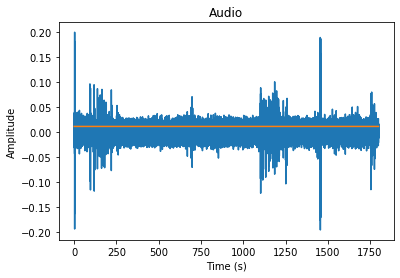

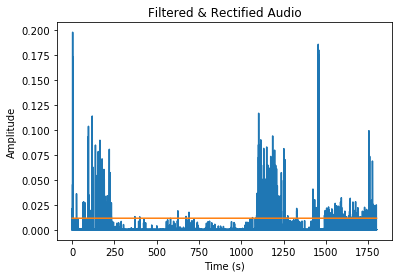

In [54]:
plt.figure()
plt.plot(np.linspace(0,len(audio_signal)/sr,len(audio_signal)), audio_signal)
plt.plot(np.linspace(0,len(audio_signal)/sr,len(audio_signal)),[th*rms]*len(audio_signal))
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.title('Audio')

plt.figure()
plt.plot(np.linspace(0,len(rf_filt_audio_signal)/sr,len(rf_filt_audio_signal)), rf_filt_audio_signal)
plt.plot(np.linspace(0,len(rf_filt_audio_signal)/sr,len(rf_filt_audio_signal)),[th*rms]*len(rf_filt_audio_signal))
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.title('Filtered & Rectified Audio')

# Create an array of 0 and 1 

In [55]:
idx_above_th = np.argwhere(rf_filt_audio_signal > th*rms)


binary_signal = np.zeros(len(rf_filt_audio_signal))
binary_signal[idx_above_th] = 1


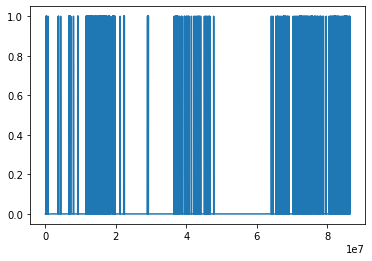

In [32]:
plt.plot(binary_signal)

In [56]:
start_end_idxs = []
start_idx = None 
end_idx = None 
zero_counter = 0
samples_between_poi = 2*sr
min_samples_poi = sr/2  # Only save if song is of at least 0.5 seconds (discard random noisy threshold crossings)

for i in range(len(binary_signal)):
    
    if binary_signal[i] == 1:
        if start_idx == None:
            start_idx = i
        
        elif zero_counter != 0 or end_idx is not None:
            zero_counter = 0
            end_idx = None
            
    elif binary_signal[i] == 0:

        if start_idx != None:
            if zero_counter == 0: 
                end_idx = i
                zero_counter += 1
                
            elif zero_counter < samples_between_poi:
                zero_counter += 1
                
            elif zero_counter >= samples_between_poi:
                if end_idx - start_idx > min_samples_poi:  
                    start_end_idxs.append([start_idx, end_idx])
                start_idx = None
                end_idx = None
                zero_counter = 0
    
    # If we are in a poi and the file ends
    if i == len(binary_signal)-1 and start_idx != None:
        start_end_idxs.append([start_idx, i])
        
        

In [57]:
print('Song found in {} periods'.format(len(start_end_idxs)))

for k in range(len(start_end_idxs)):
    print('song apeared in ' + str(start_end_idxs[k]))

Song found in 53 periods
song apeared in [38049, 297412]
song apeared in [4440994, 4780269]
song apeared in [5352580, 5445392]
song apeared in [5546569, 5727472]
song apeared in [5833696, 5865965]
song apeared in [6785807, 7099742]
song apeared in [7776164, 8037159]
song apeared in [8425823, 8491167]
song apeared in [9967998, 10037826]
song apeared in [10429944, 10552658]
song apeared in [10675825, 10731018]
song apeared in [30003884, 30031504]
song apeared in [52288005, 52426171]
song apeared in [52812792, 52973447]
song apeared in [53168303, 53227120]
song apeared in [53485542, 53539014]
song apeared in [54324610, 54384180]
song apeared in [55133910, 55255020]
song apeared in [55527760, 56189072]
song apeared in [56359094, 56400751]
song apeared in [56573927, 57267585]
song apeared in [57468617, 57530615]
song apeared in [57941528, 58096109]
song apeared in [58200650, 58477182]
song apeared in [58848910, 58907001]
song apeared in [60003031, 60085284]
song apeared in [60341337, 604361

In [36]:
os.chdir(path_save + (os.path.relpath(os.getcwd(), path_load)))
os.getcwd()

FileNotFoundError: [Errno 2] No such file or directory: '/net/expData/speech_bci/processed_data/audio_habituation/../processed_data/audio_habituation'

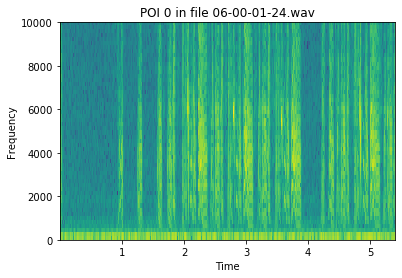

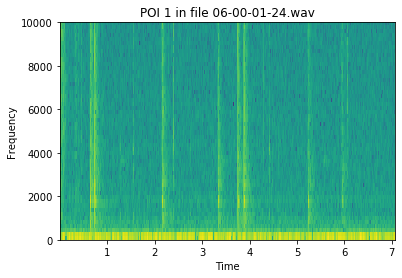

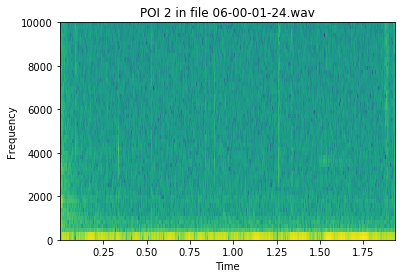

In [84]:
# As many times as you like, create a figure fig and save it:
for poi in range(3):
    
    
# lr.output.write_wav('POI' + str(poi) + '.wav', audio_signal[start_end_idxs[poi][0]:start_end_idxs[poi][1]], sr)
# poi = 0
    signal2plot = audio_signal[start_end_idxs[poi][0]:start_end_idxs[poi][1]]

    plt.figure()
    powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(signal2plot, Fs=sr)
    plt.axis(ymin=0, ymax=10000)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title('POI {} in file {}'.format(poi, audio_files[1]))

In [87]:
a = []
a.append([1,2,3])
a.append([4,5,6])
len(a)

2

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


pdf = PdfPages("POIs.pdf")

# As many times as you like, create a figure fig and save it:
for poi in range(3):
    
    
    lr.output.write_wav('POI' + str(poi) + '.wav', audio_signal[start_end_idxs[poi][0]:start_end_idxs[poi][1]], sr)
    
    signal2plot = audio_signal[start_end_idxs[poi][0]:start_end_idxs[poi][1]]
    
    plt.figure()
    plt.plot(np.linspace(0,len(signal2plot)/sr,len(signal2plot)), signal2plot)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.title('POI {} in file {}'.format(poi, audio_files[1]))

    # When no figure is specified the current figure is saved
#     pdf.savefig()
    


pdf.close()


AttributeError: module 'librosa' has no attribute 'output'

In [7]:
from pathlib import Path
Path(path_save + (os.path.relpath(os.getcwd(), path_load))).mkdir(parents=True, exist_ok=True)

In [19]:
os.path.relpath(pathname, path_save)

'../../raw_data/z_g12g8_20/2020-08-03'

In [17]:
pathname = '/net/expData/speech_bci/raw_data/z_g12g8_20/2020-08-03/'

In [29]:
# Save .wav files of snippets

import soundfile as sf
sf.write('POI' + str(poi) + '.wav', audio_signal[start_end_idxs[poi][0]:start_end_idxs[poi][1]], sr)

AttributeError: module 'librosa' has no attribute 'output'

In [3]:
# for x in os.walk(path_load):
#     os.chdir(x[0])
    
pathname = '/net/expData/speech_bci/raw_data/'
bird1 = 'z_g12g8_20/2020-08-04/'
bird2 = 'z_r20g12_20/2020-08-03'

os.chdir(pathname + bird1)
audio_files = glob('*.wav') # Retrieve all .wav files in folder
audio_files

['06-00-01-06.wav',
 '06-00-01-24.wav',
 '06-00-01-19.wav',
 '06-00-01-11.wav',
 '06-00-01-28.wav',
 '06-00-01-22.wav',
 '06-00-01-02.wav',
 '06-00-01-03.wav',
 '06-00-01-08.wav',
 '06-00-01-12.wav',
 '06-00-01-21.wav',
 '06-00-01-14.wav',
 '06-00-01-16.wav',
 '06-00-01-26.wav',
 '06-00-01-07.wav',
 '06-00-01-05.wav',
 '06-00-01-17.wav',
 '06-00-01-10.wav',
 '06-00-01-18.wav',
 '06-00-01-15.wav',
 '06-00-01-01.wav',
 '06-00-01-04.wav',
 '06-00-01-23.wav',
 '06-00-01-25.wav',
 '06-00-01-20.wav',
 '06-00-01-09.wav',
 '06-00-01-27.wav',
 '06-00-01-13.wav']

In [5]:
af = 1

print('Working on ', pathname + bird1 + audio_files[af])

# To preserve the native sampling rate of the file, use sr=None
audio_signal, sr = lr.load(pathname + bird1 + audio_files[af], sr=None)  

# Filter audio
filt_audio_signal = noncausal_filter(audio_signal, b, a=a)

# Rectify audio signal
rf_filt_audio_signal = np.absolute(filt_audio_signal)

Working on  /net/expData/speech_bci/raw_data/z_g12g8_20/2020-08-04/06-00-01-24.wav


In [ ]:
plt.figure()
plt.plot(np.linspace(0,len(audio_signal)/sr,len(audio_signal)), audio_signal)
plt.plot(np.linspace(0,len(audio_signal)/sr,len(audio_signal)),[th*rms]*len(audio_signal))
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.title('Audio')

plt.figure()
plt.plot(np.linspace(0,len(rf_filt_audio_signal)/sr,len(rf_filt_audio_signal)), rf_filt_audio_signal)
plt.plot(np.linspace(0,len(rf_filt_audio_signal)/sr,len(rf_filt_audio_signal)),[th*rms]*len(rf_filt_audio_signal))
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.title('Filtered & Rectified Audio')

Text(0.5, 1.0, 'Filtered & Rectified Audio')

In [6]:
# Calculate RMS of audio signal
rms = calculate_signal_rms(rf_filt_audio_signal)

# Create binary vector of indexes where the audio crosses the specified threshold
idx_above_th = np.argwhere(rf_filt_audio_signal > th*rms)
binary_signal = np.zeros(len(rf_filt_audio_signal))
binary_signal[idx_above_th] = 1

In [8]:
# Retrieve start / end sample index for each Period of Interest found.
samples_between_poi = 2*sr  # Number of samples needed to consider two POIs independent.
min_samples_poi = sr/2  # Only save POI if it's at least 0.5 seconds long (discard random noisy threshold crossings)
start_end_idxs = find_start_end_idxs_POIs(binary_signal, samples_between_poi, min_samples_poi=min_samples_poi)

print('Song found in {} periods'.format(len(start_end_idxs)))
for k in range(len(start_end_idxs)):
    print('song apeared in ' + str(start_end_idxs[k]))

Song found in 72 periods
song apeared in [182519, 455723]
song apeared in [684008, 760553]
song apeared in [1122970, 1419085]
song apeared in [3649941, 3708727]
song apeared in [4286227, 4473050]
song apeared in [5286687, 5333065]
song apeared in [6594774, 7116187]
song apeared in [7604695, 7836289]
song apeared in [8883977, 8971879]
song apeared in [9164635, 9294577]
song apeared in [11304619, 11337704]
song apeared in [11450581, 13590099]
song apeared in [13823676, 14643438]
song apeared in [14920564, 15755223]
song apeared in [15888981, 17391897]
song apeared in [17830207, 18473049]
song apeared in [18919525, 19372887]
song apeared in [19608455, 19755327]
song apeared in [19892798, 19951589]
song apeared in [20297190, 20496441]
song apeared in [20651282, 20698276]
song apeared in [21217710, 21248358]
song apeared in [22149779, 22402895]
song apeared in [22570903, 22632966]
song apeared in [24304396, 24369538]
song apeared in [24572460, 24688144]
song apeared in [28260269, 28332374]


In [7]:



# Plot snippets of POIs and save them:
for poi in range(len(start_end_idxs)):
    signal2plot = audio_signal[start_end_idxs[poi][0]:start_end_idxs[poi][1]]

    plt.figure()
    plt.plot(np.linspace(0,len(signal2plot)/sr,len(signal2plot)), signal2plot)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.title('POI {} in file {}'.format(poi, audio_files[1]))

    # When no figure is specified the current figure is saved
    pdf.savefig()

    # Save .wav files of snippets
    lr.output.write_wav('POI' + str(poi) + '.wav', audio_signal[start_end_idxs[poi][0]:start_end_idxs[poi][1]], sr)


pdf.close()

Song found in 0 periods


NameError: name 'pdf' is not defined

In [95]:
'''IMPORTS'''

import numpy  as np    #for numerical computation
from glob import glob  #for reading files
from scipy.io import loadmat  #for loading .mat files from matlab (loading a,b for the butter filter)
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt  #visualization  of audio files amplitude, It provides a MATLAB-like way of plotting.
from math import pi
import librosa as lr 
import soundfile as sf
import os
from pathlib import Path
from scipy import signal
import math 
from scipy.signal import filtfilt
import numpy as np 
from matplotlib.backends.backend_pdf import PdfPages  # Deal with PDFs

from audio_autoSegmentation_helper import *



'''DATA PATHS'''
path_load = '/net/expData/speech_bci/raw_data/'
path_save = '/net/expData/speech_bci/processed_data/audio_habituation/'

'''VARIABLES'''
th = 8  # Amplitude Detection Threshold -> # of standard devioations above rms for song detection
    
'''FILTER'''
# # b, a = load_filter_coefficients_matlab('/home/jovyan/pablo_tostado/bird_song/filters/butter_hp_250hz_order4.mat')
# b, a = load_filter_coefficients_matlab('/home/jovyan/pablo_tostado/bird_song/filters/butter_bp_250hz-8000hz_order4.mat')
b, a = load_filter_coefficients_matlab('/home/pablotostado/pablo_tostado/bird_song/filters/butter_bp_250hz-8000hz_order4.mat')
    
    
    
'''CODE'''
    
# for x in os.walk(path_load):
#     x[0].replace("/", "_")
#     print(x[0])
    
# pathname = '/net/expData/speech_bci/raw_data/'

# bird = 'z_g12g8_20'
# session = '2020-08-04'

# bird = 'z_r20y12_20'
# session = '2020-08-05'
for x in os.walk(path_load):
    os.chdir(x[0])
    audio_files = glob('*.wav') # Retrieve all .wav files in folder

    if audio_files:

        # Get Bird & Session names to store results
        path = os.path.normpath(x[0])
        path_folders = path.split(os.sep)
        bird = path_folders[-2]
        session = path_folders[-1]
        print('Segmenting bird:', bird, ', session:', session)

        # Create folder where to store data if it does not exist already and change directory.
        Path(path_save + bird + '/' + session + '/').mkdir(parents=True, exist_ok=True)
        os.chdir(path_save + bird + '/' + session + '/')

        # Create pdf to save snippets of POIs found (waveforms & spectrograms).
        pdf_wave = PdfPages('POIs_pressureWave_' + str(bird) + '_' + str(session) + '.pdf')
        pdf_spectrogram = PdfPages('POIs_spectrogram_' + str(bird) + '_' + str(session) + '.pdf')

        
        pois = []
        for af in audio_files:
            
            print('Loading file: ', af)

            # To preserve the native sampling rate of the file, use sr=None
            audio_signal, sr = lr.load(x[0] + '/' + af, sr=None)  

            # Filter audio
            filt_audio_signal = noncausal_filter(audio_signal, b, a=a)

            # Rectify audio signal
            rf_filt_audio_signal = np.absolute(filt_audio_signal)

            # Calculate RMS of audio signal
            rms = calculate_signal_rms(rf_filt_audio_signal)

            # Create binary vector of indexes where the audio crosses the specified threshold
            idx_above_th = np.argwhere(rf_filt_audio_signal > th*rms)
            binary_signal = np.zeros(len(rf_filt_audio_signal))
            binary_signal[idx_above_th] = 1

            # Retrieve start / end sample index for each Period of Interest found.
            samples_between_poi = 2*sr  # Number of samples needed to consider two POIs independent.
            min_samples_poi = sr/2  # Only save POI if it's at least 0.5 seconds long (discard random noisy threshold crossings)
            start_end_idxs = find_start_end_idxs_POIs(binary_signal, samples_between_poi, min_samples_poi=min_samples_poi)

            # Store all POIs:
            for poi in range(len(start_end_idxs)):
                signal = audio_signal[start_end_idxs[poi][0]:start_end_idxs[poi][1]]
                pois.append(signal)
            
        print('Found {} POIs in session {}'.format(len(pois), session))

Segmenting bird: z_g15o3_20 , session: 2020-08-03
Loading file:  08-00-15-10.wav
Loading file:  08-00-15-20.wav


KeyboardInterrupt: 

In [96]:
print('Found {} POIs in session {}'.format(len(pois), session))

Found 15 POIs in session 2020-08-03


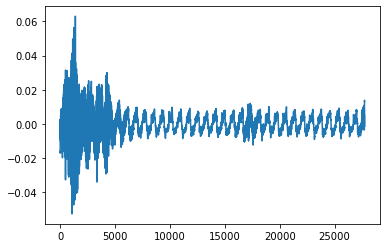

In [101]:
plt.plot(pois[14])

In [105]:
np.min((13, 101))

13